# Problem Description

## `parsing_metadata.py` doesn't correctly save ALL THE ROIs from the xmls to mask pngs.

Below  is an example, for which, even though `rois_df` has a `True` value in the `stored` column for all 'calcification' ROIs, only one ROI of mC is stored in the final mask.

To run the notebook put it in the `notebooks/` folder

In [1]:
from tqdm import tqdm

In [2]:
import sys; sys.path.insert(0, '..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from database.dataset import INBreast_Dataset

from pathlib import Path
from tqdm import tqdm
import cv2
import os
import ast

from skimage import restoration
# from dehazing import dehaze


We are using the latest dataset class from `dev` and re-running the latest version of parsing script from `dev`

In [3]:
db = INBreast_Dataset(
        return_lesions_mask=True,
        level='image',
        max_lesion_diam_mm=100,
        extract_patches=True,
        extract_patches_method='all',  # 'centered'
        patch_size=256,
        lesion_types = ['mass'],
        stride=256,
        min_breast_fraction_roi=0.5,
        normalize=None,
        cropped_imgs=True,
        n_jobs=-1,
)

In [4]:
img_id =  22579730 # one image for which the problem exists

problem_index = db.df[db.df.img_id == img_id].index[0] # should be 38
db.rois_df.loc[db.rois_df.img_id==22579730, 'lesion_type']

25    mass
26    mass
Name: lesion_type, dtype: object

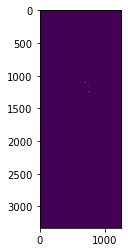

In [64]:
plt.imshow(mask)

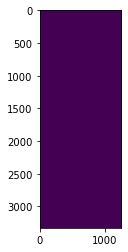

In [67]:
mask = db[problem_index]['lesion_mask'].astype('float32')
mask = np.zeros(mask.shape).astype('float32')
holes = mask.copy()
cv2.floodFill(holes, None, (0, 0), newVal=1)
holes = np.where(holes == 0, 255, 0)
mask = (mask + holes).astype('uint8')
plt.imshow(mask)

In [7]:
img_id =  22579730 # one image for which the problem exists

problem_index = db.df[db.df.img_id == img_id].index[0] # should be 38
# assert problem_index == 38

# problem_index
print(len(db[problem_index]['lesion_bboxes']))

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'floodFill'
> Overload resolution failed:
>  - floodFill() missing required argument 'mask' (pos 2)
>  - floodFill() missing required argument 'mask' (pos 2)


In [61]:
problem_index

34

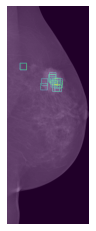

In [62]:
roi_mask = np.zeros(db[problem_index]['img'].shape)
for i in db[problem_index]['lesion_bboxes']:
    roi_mask = cv2.rectangle(roi_mask, (i[0][0]-50, i[0][1]-50), (i[1][0]+50, i[1][1]+50), 255, 3)
plt.figure()
plt.imshow(db[problem_index]['img'], cmap='gray' )
plt.imshow(roi_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [63]:
mask_path = db.full_mask_path / f'{img_id}_lesion_mask.png'
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
print(len(np.unique(mask)))
np.unique(mask, return_counts=True)

20


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint8),
 array([4030420,       1,       1,      29,       1,       1,       1,
              1,       1,      87,       1,       1,  120845,     104,
              1,       1,       1,   11829,       1,       1]))

In [68]:
db[problem_index].keys()

dict_keys(['idx', 'lab', 'img', 'lesion_bboxes', 'lesion_mask', 'side'])

In [70]:
mask_path = db.full_mask_path / f'{img_id}_lesion_mask.png'
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))
print('original unfiltered mask:\t', np.unique(mask, return_counts=True))
print("However in the original mask we can find only 3 ROIs")
mask = db.adjust_mask_to_selected_lesions(mask, problem_index)
print(len(np.unique(mask)))
print('\nfiltered mask', np.unique(mask, return_counts=True))
print(len(db[problem_index]['lesion_bboxes']))
# print('\nfiltered mask', np.unique(db[problem_index]['lesion_mask'], return_counts=True))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
original unfiltered mask:	 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8), array([4030420,       1,       1,      29,       1,       1,       1,
             1,       1,      87,       1,       1,  120845,     104,
             1,       1,       1,   11829,       1,       1]))
However in the original mask we can find only 3 ROIs
18

filtered mask (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 18,
       19], dtype=uint8), array([4163094,       1,       1,      29,       1,       1,       1,
             1,       1,      87,       1,       1,     104,       1,
             1,       1,       1,       1]))
17


We see that filtering reduced number of ROIs in the mask from 3 to 1, even though we initially had to have 17

From df below we can see that they all should have been stored in the mask, and that 12 and 17 are correctly filtered non calcification ROIs.

But we are still missing our 16 calcification ROIs

In [11]:
df_temp = pd.read_csv('/home/jseia/Desktop/ml-dl/calc-det/data/INbreast Release 1.0/rois_metadata.csv')

In [29]:
df_temp.loc[(df_temp.img_id == img_id) & (df_temp.index_in_image == 17), 'lesion_type']

1004    mass
Name: lesion_type, dtype: object

In [40]:

np.unique(mask, return_counts=True)

(array([ 0,  1,  2, 12, 13, 14, 15, 16, 17, 18, 19], dtype=uint8),
 array([4030420,       1,       1,  120968,     104,       1,       1,
              1,   11829,       1,       1]))

In [39]:
df_temp.loc[df_temp.img_id == img_id,['radius', 'index_in_image', 'center_crop']]

,radius,index_in_image,center_crop
1003,0.000100,2,"(1000, 926)"
1004,74.222092,17,"(862, 951)"
1005,6.955928,13,"(503, 1246)"
1006,0.000100,14,"(688, 1231)"
1007,0.000100,15,"(474, 1210)"
1008,0.000100,16,"(452, 1193)"
1009,0.000100,10,"(555, 1094)"
1010,0.000100,18,"(531, 1187)"
1011,0.000100,19,"(470, 1255)"
1012,0.000100,1,"(1005, 920)"


In [21]:
db.rois_df[db.rois_df.img_id == img_id]['index_in_image'].sort_values()

920     1
912     2
928     3
927     4
926     5
925     6
924     7
923     8
922     9
917    10
921    11
913    13
914    14
915    15
916    16
918    18
919    19
Name: index_in_image, dtype: int64

We can also see that among those ROIs that weren't saved in the mask, some have are, so are not single pixel segmentations. And since `stored` == `True` for them, the problem probably wasn't the image boundary. 

In [10]:
4*2*0.7

5.6

In [41]:
db.rois_df[db.rois_df.img_id == img_id]

,case_id,img_id,side,view,area,center,center_crop,dev,index_in_image,max,...,micros,distortion,asymmetry,finding_notes,lesion_annot,pectoral_muscle,artifact,lesion_type,radius,partition
880,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1840, 1187)","(720, 1187)",0.000000,18,3300.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
881,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1988, 1160)","(572, 1160)",0.000000,5,3448.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
882,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1845, 1147)","(715, 1147)",0.000000,4,3617.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
883,bbd6a3a35438c11b,22579730,R,MLO,0.001568,"(1818, 1161)","(742, 1161)",221.736923,3,3715.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,4.000100,train
884,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1779, 1255)","(781, 1255)",0.000000,19,3493.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
885,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(2309, 926)","(251, 926)",0.000000,2,1634.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
886,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(2314, 920)","(246, 920)",0.000000,1,1935.0,...,1.0,0.0,0.0,2 nódulos + micros,yes,False,False,calcification,0.000100,train
887,bbd6a3a35438c11b,22579730,R,MLO,0.003825,"(1872, 1104)","(688, 1104)",249.826996,9,3976.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,5.700977,train
888,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1862, 1068)","(698, 1068)",0.000000,8,3671.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train
889,bbd6a3a35438c11b,22579730,R,MLO,0.000000,"(1864, 1094)","(696, 1094)",0.000000,10,3458.0,...,True,False,False,2 nódulos + micros,yes,False,False,calcification,0.000100,train


In [53]:
bad_imgs = []
for i in tqdm(range(310), total=310):
    if db[i]['lesion_bboxes'] != len(db.rois_df[db.rois_df.img_id == db.img_df.iloc[i].img_id]):
        bad_imgs.append(i)

100%|██████████| 310/310 [00:49<00:00,  6.31it/s]


In [54]:
len(bad_imgs)/310

1.0